# Tutorial 11-4: The Art Forger – "Building a DCGAN"

**Course:** CSEN 342: Deep Learning  
**Topic:** Generative Adversarial Networks (GANs), Convolutional Generators, and Minimax Games

## Objective
A **GAN** consists of two networks fighting against each other:
1.  **The Generator (G):** Tries to create fake images that look real.
2.  **The Discriminator (D):** Tries to distinguish between real images from the dataset and fake images from G.

The training process is a **Minimax Game** (Slide 10):
$$ \min_G \max_D V(D, G) = \mathbb{E}_{x \sim p_{data}} [\log D(x)] + \mathbb{E}_{z \sim p_z} [\log(1 - D(G(z)))] $$

In this tutorial, we will build a **DCGAN** (Deep Convolutional GAN) to generate images resembling CIFAR-10.

---

## Part 1: Data Preparation

We use CIFAR-10. 
**Important:** The Generator's final layer is usually `Tanh`, which outputs values in $[-1, 1]$. Therefore, we must normalize our real images to this same range.

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import torchvision.utils as vutils
import matplotlib.pyplot as plt
import numpy as np
import os

# 1. Configuration
batch_size = 128
image_size = 32 # CIFAR-10 is 32x32
nz = 100        # Size of z latent vector (the input to the generator)
ngf = 64        # Size of feature maps in generator
ndf = 64        # Size of feature maps in discriminator
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 2. Data Loading
data_root = '../data'
os.makedirs(data_root, exist_ok=True)

transform = transforms.Compose([
    transforms.Resize(image_size),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)), # Normalize to [-1, 1]
])

dataset = torchvision.datasets.CIFAR10(root=data_root, train=True, download=True, transform=transform)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

print(f"Data loaded: {len(dataset)} images.")

Files already downloaded and verified
Data loaded: 50000 images.


---

## Part 2: The Forger (Generator)

The Generator takes a latent vector $z$ and upsamples it using `ConvTranspose2d` layers.

**Architecture Guidelines (Slide 17):**
* Use `ReLU` activation for all layers except the output.
* Use `Tanh` for the output layer.
* Use Batch Normalization.

In [2]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            # Input is Z, going into a convolution
            # Start: (nz) x 1 x 1 -> 4x4 feature map
            nn.ConvTranspose2d(nz, ngf * 4, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            
            # State size: (ngf*4) x 4 x 4
            # Up to 8x8
            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            
            # State size: (ngf*2) x 8 x 8
            # Up to 16x16
            nn.ConvTranspose2d(ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            
            # State size: (ngf) x 16 x 16
            # Final layer: Up to 32x32 image (3 channels)
            nn.ConvTranspose2d(ngf, 3, 4, 2, 1, bias=False),
            nn.Tanh() # Squeeze to [-1, 1]
            # Final state size: 3 x 32 x 32
        )

    def forward(self, input):
        return self.main(input)

netG = Generator().to(device)
print(netG)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 256, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): Tanh()
  )
)


## Part 3: The Detective (Discriminator)

The Discriminator is a standard binary classifier CNN.

**Architecture Guidelines (Slide 18):**
* Use **LeakyReLU** activation (slope 0.2) to prevent sparse gradients.
* Use `Sigmoid` at the end to output a probability (Real vs Fake).

In [3]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            # Input is (3) x 32 x 32
            nn.Conv2d(3, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            
            # State: (ndf) x 16 x 16
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            
            # State: (ndf*2) x 8 x 8
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            
            # State: (ndf*4) x 4 x 4
            # Output probability
            nn.Conv2d(ndf * 4, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input).view(-1, 1).squeeze(1)

netD = Discriminator().to(device)
print(netD)

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (9): Sigmoid()
  )
)


---

## Part 4: The Training Loop (The Game)

We define the loss function (Binary Cross Entropy) and the optimizers. 
We use `Adam` with `beta1=0.5` as suggested by the DCGAN authors for stability.

**The Steps per Batch:**
1.  **Update D:** Train with real batch (Label=1). Train with fake batch generated by G (Label=0).
2.  **Update G:** Generate fake batch. Pass through D. Compute loss assuming we *wanted* D to predict Real (Label=1).

In [4]:
# Loss and Optimizers
criterion = nn.BCELoss()
optimizerD = optim.Adam(netD.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=0.0002, betas=(0.5, 0.999))

# Fixed noise for visualization (so we can see improvement on the same "seed" images)
fixed_noise = torch.randn(64, nz, 1, 1, device=device)

print("Starting Training Loop...")
num_epochs = 5

img_list = []
G_losses = []
D_losses = []

for epoch in range(num_epochs):
    for i, data in enumerate(dataloader, 0):
        # -----------------------
        # 1. Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        # -----------------------
        netD.zero_grad()
        
        # Train with Real
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), 1., dtype=torch.float, device=device)
        output = netD(real_cpu)
        errD_real = criterion(output, label)
        errD_real.backward()
        
        # Train with Fake
        noise = torch.randn(b_size, nz, 1, 1, device=device)
        fake = netG(noise)
        label.fill_(0.)
        output = netD(fake.detach()) # Detach to avoid backprop into G
        errD_fake = criterion(output, label)
        errD_fake.backward()
        
        errD = errD_real + errD_fake
        optimizerD.step()

        # -----------------------
        # 2. Update G network: maximize log(D(G(z)))
        # -----------------------
        netG.zero_grad()
        label.fill_(1.)  # Fake labels are real for generator cost
        output = netD(fake) 
        errG = criterion(output, label)
        errG.backward()
        optimizerG.step()

        # Save Losses for plotting
        G_losses.append(errG.item())
        D_losses.append(errD.item())
        
        if i % 100 == 0:
            print(f'[{epoch}/{num_epochs}][{i}/{len(dataloader)}]\tLoss_D: {errD.item():.4f}\tLoss_G: {errG.item():.4f}')

    # Save visual progress
    with torch.no_grad():
        fake = netG(fixed_noise).detach().cpu()
    img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

print("Training Finished.")

Starting Training Loop...
[0/5][0/391]	Loss_D: 1.4501	Loss_G: 1.4653
[0/5][100/391]	Loss_D: 0.2869	Loss_G: 3.7803
[0/5][200/391]	Loss_D: 0.4608	Loss_G: 5.9694
[0/5][300/391]	Loss_D: 0.3850	Loss_G: 3.9853
[1/5][0/391]	Loss_D: 0.3948	Loss_G: 3.1815
[1/5][100/391]	Loss_D: 0.2464	Loss_G: 3.4269
[1/5][200/391]	Loss_D: 0.4206	Loss_G: 2.9408
[1/5][300/391]	Loss_D: 0.5340	Loss_G: 2.8395
[2/5][0/391]	Loss_D: 0.4723	Loss_G: 2.3305
[2/5][100/391]	Loss_D: 0.4313	Loss_G: 3.4784
[2/5][200/391]	Loss_D: 0.3486	Loss_G: 3.7037
[2/5][300/391]	Loss_D: 0.4395	Loss_G: 3.9771
[3/5][0/391]	Loss_D: 0.5927	Loss_G: 2.9441
[3/5][100/391]	Loss_D: 0.4835	Loss_G: 2.2526
[3/5][200/391]	Loss_D: 0.4550	Loss_G: 2.9006
[3/5][300/391]	Loss_D: 0.4516	Loss_G: 2.8164
[4/5][0/391]	Loss_D: 0.9486	Loss_G: 1.1388
[4/5][100/391]	Loss_D: 0.3527	Loss_G: 3.7279
[4/5][200/391]	Loss_D: 0.8089	Loss_G: 1.4255
[4/5][300/391]	Loss_D: 0.5673	Loss_G: 1.9130
Training Finished.


## Part 5: Results

Let's look at the generated images. At first, they will look like static noise. As training progresses, you should start seeing shapes and colors resembling the CIFAR-10 classes (cars, birds, planes).

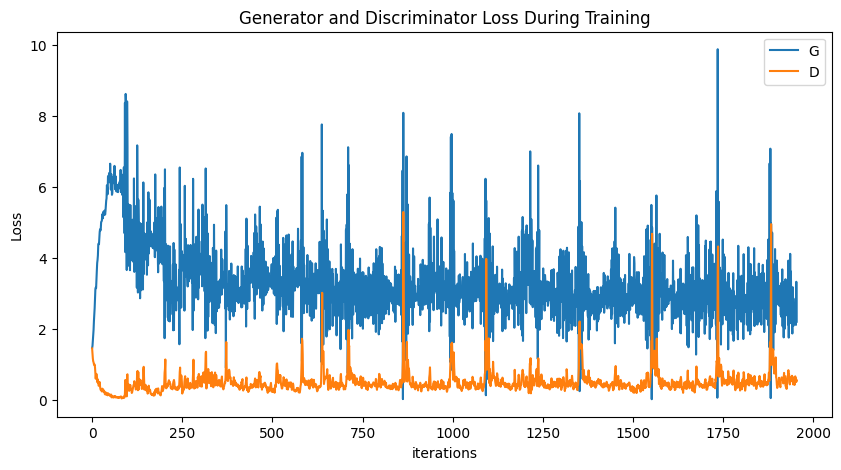

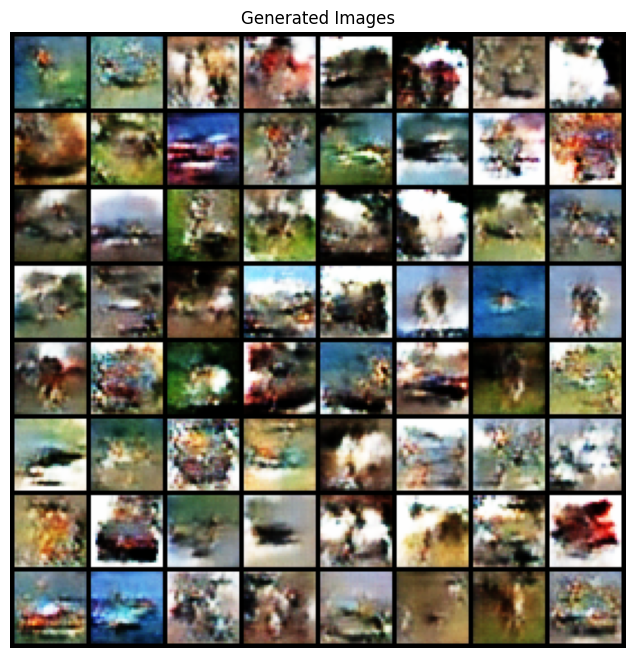

In [5]:
# Plot Loss
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses, label="G")
plt.plot(D_losses, label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

# Visualization of Final Epoch
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Generated Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()

### Conclusion
You have successfully trained a GAN! 
Notice the **Loss Plot**. In standard deep learning, we want loss to go to zero. In a GAN, we want **equilibrium** (Nash Equilibrium). Ideally, the Generator loss and Discriminator loss should stabilize around specific values, indicating that neither is winning too easily.

If D loss goes to 0 immediately, G stops learning (Vanishing Gradients). If G loss goes to 0, D is overwhelmed.